# Sentimental Analysis in Python

In [1]:
import transformers

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [29]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline

 # Should print the version if installed successfully


plt.style.use('ggplot')


import nltk
nltk.download('punkt') # for tokenzie
nltk.download('averaged_perceptron_tagger')# post_tag
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Tapas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Tapas\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\Tapas\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Tapas\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Tapas\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
df = pd.read_csv('Reviews.csv')
print(df.shape)
df = df.head(500)
print(df.shape)

(568454, 10)
(500, 10)


In [4]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


 # Quick exploratory data analysis (EDA)

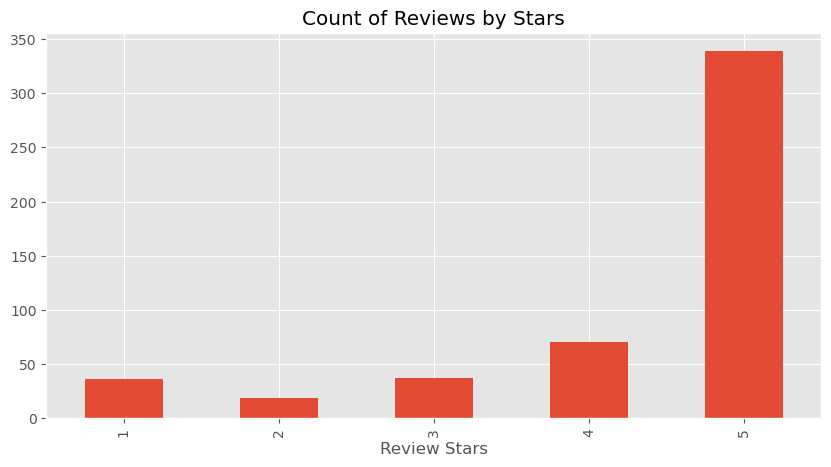

In [5]:
ax = df['Score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

In [6]:
#Basic NTLK
eg = df['Text'][50]
print(eg)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [7]:
tokens = nltk.word_tokenize(eg)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [8]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [9]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


# 1) VADER Seniment Scoring
We will use NLTK's SentimentIntensityAnalyzer to get the neg/neu/pos scores of the text.



In [10]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [11]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [12]:
sia.polarity_scores('I am very sad today.')

{'neg': 0.531, 'neu': 0.469, 'pos': 0.0, 'compound': -0.5256}

In [13]:
sia.polarity_scores(eg)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [14]:

tqdm.pandas()  # Initialize tqdm for DataFrame operatio

def get_sentiment(text):
    return sia.polarity_scores(text)

# Apply function with progress bar
df['Sentiment'] = df['Text'].progress_apply(get_sentiment)


  0%|          | 0/500 [00:00<?, ?it/s]

In [15]:
res = {}
for i, row in df.iterrows():
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)


In [16]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [17]:
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,"{'neg': 0.0, 'neu': 0.695, 'pos': 0.305, 'comp..."
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,"{'neg': 0.138, 'neu': 0.862, 'pos': 0.0, 'comp..."
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,"{'neg': 0.091, 'neu': 0.754, 'pos': 0.155, 'co..."
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,"{'neg': 0.0, 'neu': 0.552, 'pos': 0.448, 'comp..."


C:\Users\Tapas\AppData\Local\Temp\ipykernel_9356\303641165.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=vaders, x='Score', y='compound',palette=colors)


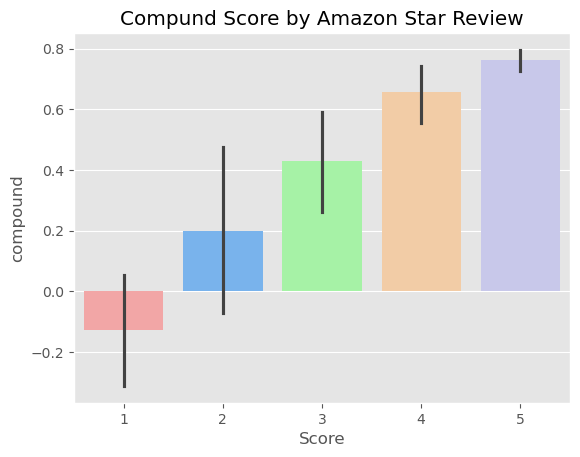

In [18]:
#PLOT VADER RESULT
colors = ["#ff9999", "#66b3ff", "#99ff99", "#ffcc99", "#c2c2f0"]
ax = sns.barplot(data=vaders, x='Score', y='compound',palette=colors)
ax.set_title('Compund Score by Amazon Star Review')
plt.show()


C:\Users\Tapas\AppData\Local\Temp\ipykernel_9356\3357320895.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0],palette=colors)
C:\Users\Tapas\AppData\Local\Temp\ipykernel_9356\3357320895.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1],palette=colors)
C:\Users\Tapas\AppData\Local\Temp\ipykernel_9356\3357320895.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2],palette=colors)


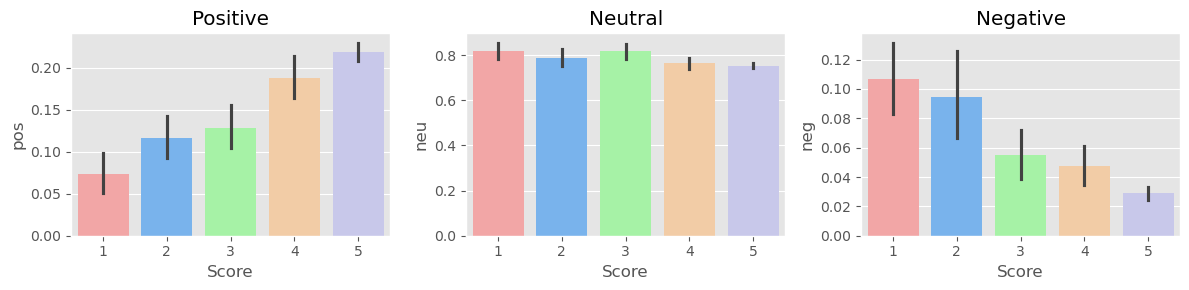

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0],palette=colors)
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1],palette=colors)
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2],palette=colors)
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# Roberta Pretrained Model 
==>It is used a model trained of a large corpus of data.

In [20]:
import sys
print(sys.executable)


C:\ProgramData\anaconda3\python.exe


In [21]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
print("Transformers library imported successfully!")


Transformers library imported successfully!


In [22]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

In [23]:
results_df.columns


Index(['Id', 'neg', 'neu', 'pos', 'compound', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text', 'Sentiment'],
      dtype='object')

In [ ]:
from transformers import pipeline
sent_pipeline('I love sentiment analysis!')

# Initialize the sentiment analysis pipeline

#https://www.kaggle.com/code/robikscube/sentiment-analysis-python-youtube-tutorial